In [1]:
import numpy as np
from skypy.pipeline import Pipeline
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import speclite.filters as spec
from astropy.modeling.models import Linear1D, Exponential1D
from astropy.units import Quantity
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(Om0=0.3, H0=70)

plt.rc('font',**{'family':'serif','size':14})
plt.rc('text', usetex=True)

In [2]:
def k_correction(sed, wave_observed, redshift, filter_abs, filter_app):
    '''Calculate the k-correction between AB-magnitudes.
    sed: array_like
        Observed flux as a function of observed wavelength.
    wave_observed: array_like
        Observed wavelength in Angstrom.
    redshift: float or array_like
        Redshift of the object.
    filter_abs, filter_app: speclite response object
        The bandpasses of the K-correction
    '''
#     print(sed.shape)
    wave_emitted = (wave_observed.T / (1+redshift)).T
#     print(wave_emitted.shape)
    frequency_emitted = 2.99e8 / (wave_emitted*10**(-10))
    frequency_observed = 2.99e8 / (wave_observed*10**(-10))
#     print("Frequency emitted: ", frequency_emitted.shape)
#     print("Frequency observed: ", frequency_observed.shape)
    
    response_emitted = np.interp(wave_emitted, filter_abs.wavelength, filter_abs.response)
    response_observed = np.interp(wave_observed, filter_app.wavelength, filter_app.response)
    int_sed_observed = np.sum(1./frequency_observed * sed * response_observed, axis=-1)
#     print(np.sum(1./frequency_observed * sed * response_observed, axis=-1).shape)
#     print("Shape int obs.: ", int_sed_observed)
    int_sed_emitted = np.sum(1./frequency_emitted * sed * response_emitted, axis=-1)
#     print("Shape int em.: ", int_sed_emitted)
    
    AB_zero = 3631 * 10**6 # in muJy and frequency space
    norm_observed = np.sum(1./frequency_observed * AB_zero * response_observed)
    norm_emitted = np.sum(1./frequency_emitted * AB_zero * response_emitted)
    
    return -2.5 * np.log10((1+redshift) * int_sed_observed/norm_observed * norm_emitted/int_sed_emitted)

def lum_model(z, M_bins):
    m_star_sf = Linear1D(-0.439, -20.623)
    m_star_q = Linear1D(-0.697, -20.372)
    phi_star_sf = Exponential1D(0.004245, -11.36364)
    phi_star_q = Exponential1D(0.005169, -1.19617)
    
    L_sf = 10 ** (0.4 * (m_star_sf(z) - M_bins[:, np.newaxis]))
    L_q = 10 ** (0.4 * (m_star_q(z) - M_bins[:, np.newaxis]))
    
    phi_model_z_sf = 0.4 * np.log(10) * phi_star_sf(z) * L_sf ** (-1.3+1) * np.exp(-L_sf)
    phi_model_z_q = 0.4 * np.log(10) * phi_star_q(z) * L_q ** (-0.5+1) * np.exp(-L_q)
    
    phi_model_sf = np.median(phi_model_z_sf, axis=1)
    phi_model_q = np.median(phi_model_z_q, axis=1)
    
    return phi_model_sf + phi_model_q

### Data
- first: simulation
- second: COSMOS

In [29]:
pipeline = Pipeline.read("/Users/philipp/Documents/PhD/lum_func_measurement/COSMOS2020_tortorelli2021.yaml")
pipeline.execute()
sim_sf = pipeline['SF']
sim_q = pipeline['Q']
sim = np.concatenate((sim_sf, sim_q))
mask = np.where((sim['m_vista_true'][:,3]+sim['m_vista_sim'][:,3]<24.5)&(sim['z']>0))[0]
sim = sim[mask]
print(len(sim))

kcorr = pyfits.open("/Users/philipp/Documents/PhD/lum_func_measurement/templates/k_nmf_derived.default.fits")

seds = kcorr[1].data
kcorr_wave = kcorr[11].data
print(kcorr_wave)
for i in range(5):
    seds[i,:] = seds[i,:] * ((kcorr_wave*kcorr_wave*1e-10)/2.99e8) * 1e29
    
i_band = spec.load_filter('hsc2017-i')
r_band = spec.load_filter('hsc2017-r')
B_band = spec.load_filter('bessell-B')

abs_mag_sim_kcorrect = np.zeros(len(sim))
sim_k_correct = np.zeros(len(sim))
for i in range(len(sim)):
    sed = np.sum(seds.T*sim['coeff'][i,:], axis=1)
    wave = kcorr_wave*(1+sim['z'][i])
    sim_k_correct[i] = k_correction(sed, wave, sim['z'][i], B_band, i_band)
    abs_mag_sim_kcorrect[i] = sim['m_hsc_true'][i,2] + sim['m_hsc_sim'][i,2] - cosmo.distmod(sim['z'][i]).value \
                                - sim_k_correct[i]

565112
[6.0025757e+02 6.0077289e+02 6.0128870e+02 ... 3.1931410e+06 3.1958825e+06
 3.1986262e+06]


In [4]:
pipeline = Pipeline.read("/Users/philipp/Documents/PhD/lum_func_measurement/COSMOS2020_Will.yaml")
pipeline.execute()
sim_sf = pipeline['SF']
sim_q = pipeline['passive_1']
sim_q2 = pipeline['passive_2']
sim_will = np.concatenate((sim_sf, np.concatenate((sim_q, sim_q2))))
mask = np.where((sim_will['m_vista_true'][:,3]+sim_will['m_vista_sim'][:,3]<24.5)&(sim_will['z']>0))[0]
sim_will = sim_will[mask]
print(len(sim_will))

kcorr = pyfits.open("/Users/philipp/Documents/PhD/lum_func_measurement/templates/k_nmf_derived.default.fits")

seds = kcorr[1].data
kcorr_wave = kcorr[11].data
for i in range(5):
    seds[i,:] = seds[i,:] * ((kcorr_wave*kcorr_wave*1e-10)/2.99e8) * 1e29
    
i_band = spec.load_filter('hsc2017-i')
r_band = spec.load_filter('hsc2017-r')
B_band = spec.load_filter('bessell-B')

abs_mag_sim_will_kcorrect = np.zeros(len(sim_will))
sim_will_k_correct = np.zeros(len(sim_will))
for i in range(len(sim_will)):
    sed = np.sum(seds.T*sim_will['coeff'][i,:], axis=1)
    wave = kcorr_wave*(1+sim_will['z'][i])
    sim_will_k_correct[i] = k_correction(sed, wave, sim_will['z'][i], B_band, i_band)
    abs_mag_sim_will_kcorrect[i] = sim_will['m_hsc_true'][i,2] + sim_will['m_hsc_sim'][i,2] - cosmo.distmod(sim_will['z'][i]).value \
                                - sim_will_k_correct[i]

676728


In [5]:
cosmos = pyfits.open("/Users/philipp/Documents/PhD/Data/COSMOS2020_Classic_processed.fits")[1].data
mask = np.where((23.9-2.5*np.log10(cosmos['UVISTA_Ks_FLUX_APER3'])<25.5)&(cosmos['photoz']>0))[0]
cosmos = cosmos[mask]
cosmos_abs_mag = pyfits.open("/Users/philipp/Documents/PhD/Data/Cosmos_Classic_absolute_mags.fits")[1].data['AbsMag']
cosmos_k_correct = pyfits.open("/Users/philipp/Documents/PhD/Data/Cosmos_Classic_absolute_mags.fits")[1].data['K-Correction']
print(len(cosmos))
print(len(cosmos_abs_mag))
print('#######')

mask = np.where((cosmos['photoz']>0) &
                (cosmos['photoz']<8.) &
                 (23.9-2.5*np.log10(cosmos['UVISTA_Ks_FLUX_APER3'])<24.5) &
                (cosmos['lp_type']==0))[0]
cosmos = cosmos[mask]
cosmos_abs_mag = cosmos_abs_mag[mask]
cosmos_k_correct = cosmos_k_correct[mask]
print(len(cosmos))
print(len(cosmos_abs_mag))
print(len(cosmos_k_correct))

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


441277
441277
#######
261209
261209
261209


### Implementation from Will

In [6]:
def Vmax(zlo, zhi, z, mag_lim, mag, zarr, dm, vol):
    # compute the maximum observable volume an object has within the defined bin
    dz = zarr[1] - zarr[0]
    m_diff = mag_lim - mag # how far above the flux limit is it?
    max_dm = dm[-1] - dm[np.where(z+dz/2>zarr)[0][-1]] # why z + dz
    if max_dm > m_diff: # why comparing max_dm and m_diff
        # find max z
        max_z_indx = np.where(dm<dm[np.where(z+dz/2>zarr)[0][-1]]+m_diff)[0][-1]
        vmax = vol[max_z_indx] - vol[0]
    else:
        vmax = vol[-1] - vol[0]
    return vmax

def get_dm(z, cosmo):
    return 5*np.log10(cosmo.luminosity_distance(z).value * 1e5) - 2.5*np.log10(1+z)

def get_bin_weights(z, cosmo, area, zbin, mag, maglim):
    # compute Vmax for each object, based on their mag and survey maglim.
    # Objects lying outside the redshift intervals have weight = 0.
    # Set-up cosmo arrays
    zarr = np.arange(zbin[0], zbin[1]+(zbin[1]-zbin[0])/1000, (zbin[1]-zbin[0])/1000)
    # set up an array of dist. moduli - perhaps should have done this earlier in the code.
    dm = get_dm(zarr, cosmo)
    vol = (area/41252.96) * cosmo.comoving_volume(zarr).value

    weights = np.zeros_like(z)
    sel = np.where((z>=zbin[0])&(z<zbin[1]))[0]
    weights[sel] = np.array([1./Vmax(zbin[0], zbin[1], z[sel][j], maglim, mag[sel][j], zarr, dm,
                                     vol) for j in range(len(sel))])
    weights[np.isinf(weights)] = 0.
    return weights

def effective_weight(inv_vmax, completeness_weights=None):
    # compute the effective weight in a luminosity bin
    if completeness_weights is None:
        weff = np.sum(inv_vmax**2) / np.sum(inv_vmax)
    else:
        weff = np.sum((completeness_weights*inv_vmax)**2) / np.sum(completeness_weights*inv_vmax)
    return weff

def effective_number(inv_vmax, weff, completeness_weights=None):
    if completeness_weights is None:
        Neff = np.sum(inv_vmax) / weff
    else:
        Neff = np.sum(completeness_weights*inv_vmax) / weff
    return Neff

In [8]:
redshift_range = [0.2, 0.4]

In [11]:
weights = get_bin_weights(cosmos['photoz'], cosmo, 1.27, redshift_range, cosmos['UVISTA_Ks_MAG_APER3'], 35)

In [14]:
weights_sim = get_bin_weights(sim['z'], cosmo, 1.27, redshift_range, sim['m_vista_sim'][:,3], 35)

KeyboardInterrupt: 

In [ ]:
# calculate the luminosity functions
Mbins = np.arange(-27,-12+0.2,0.2)
phi = np.histogram(cosmos_abs_mag, weights=weights, bins=Mbins)[0]
phi_sim = np.histogram(abs_mag_sim_kcorrect, weights=weights_sim, bins=Mbins)[0]

bin_widths = Mbins[1:] - Mbins[:-1]
phi = phi / bin_widths
phi_sim = phi_sim / bin_widths
Mmid = (Mbins[1:] + Mbins[:-1])/2.

# calculate errors for COSMOS
weff = np.ones_like(phi)
Neff = np.ones_like(phi)
for lbin in range(len(Mbins)-1):
    # Following Weigel+15
    mask = np.where((cosmos_abs_mag>=Mbins[lbin])&(cosmos_abs_mag<Mbins[lbin+1]))[0]
    weff[lbin] = effective_weight(weights[mask])
    Neff[lbin] = effective_number(weights[mask], weff[lbin])
phi_err_up = weff * (Neff + np.sqrt(Neff+0.75) + 1) / bin_widths - phi
phi_err_dn = phi - weff * (Neff - np.sqrt(Neff-0.25)) / bin_widths
# handle cases where N is zero - upper limit is 0.814 / max(Vmax)
phi_err_dn[np.isnan(phi_err_dn)] = 0.
phi_err_up[np.isnan(phi_err_up)] = 0.814 * np.min(weights[weights>0.])

# calculate errors for Sim
weff_sim = np.ones_like(phi_sim)
Neff_sim = np.ones_like(phi_sim)
for lbin in range(len(Mbins)-1):
    # Following Weigel+15
    mask = np.where((abs_mag_sim_kcorrect>=Mbins[lbin])&(abs_mag_sim_kcorrect<Mbins[lbin+1]))[0]
    weff_sim[lbin] = effective_weight(weights_sim[mask])
    Neff_sim[lbin] = effective_number(weights_sim[mask], weff_sim[lbin])
phi_err_up_sim = weff_sim * (Neff_sim + np.sqrt(Neff_sim+0.75) + 1) / bin_widths - phi_sim
phi_err_dn_sim = phi_sim - weff_sim * (Neff_sim - np.sqrt(Neff_sim-0.25)) / bin_widths
# handle cases where N is zero - upper limit is 0.814 / max(Vmax)
phi_err_dn_sim[np.isnan(phi_err_dn_sim)] = 0.
phi_err_up_sim[np.isnan(phi_err_up_sim)] = 0.814 * np.min(weights_sim[weights_sim>0.])

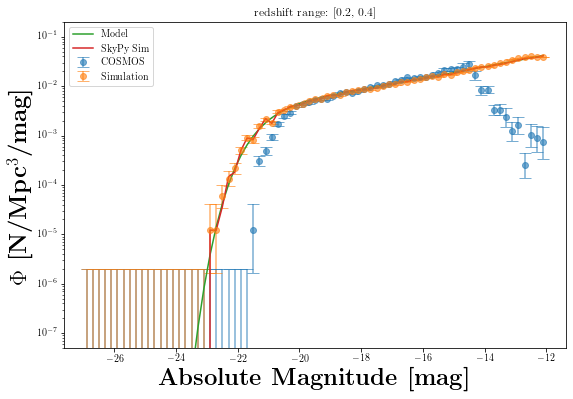

In [11]:
z = np.linspace(redshift_range[0], redshift_range[1], 100)
sky_area = Quantity(1.27, "deg2")
phi_model = lum_model(z, Mmid)

z_mask = np.logical_and(sim['z'] >= redshift_range[0], sim['z'] < redshift_range[1])
dV_dz = (cosmo.differential_comoving_volume(z) * sky_area).to_value('Mpc3')
dV = np.trapz(dV_dz, z)
dM = (np.max(Mbins)-np.min(Mbins)) / (np.size(Mbins)-1)
phi_skypy = np.histogram(sim['M_B'][z_mask], bins=Mbins)[0] / dV / dM

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"\textbf{Absolute Magnitude [mag]}", fontsize=24)
ax.set_ylabel(r'\textbf{$\Phi$ [N/Mpc$^3$/mag]}', fontsize=24)
#ax.set_xlim([-27,-12.5])
#ax.set_ylim([5.e-7,0.15])
ax.set_yscale('log')
ax.errorbar(Mmid, phi, yerr=np.array([phi_err_dn,phi_err_up]), alpha=0.6,
            fmt='o', capsize=6, label="COSMOS")
ax.errorbar(Mmid, phi_sim, yerr=np.array([phi_err_dn_sim,phi_err_up_sim]), alpha=0.6,
            fmt='o', capsize=6, label="Simulation")
ax.plot(Mmid, phi_model, label="Model")
ax.plot(Mmid, phi_skypy, label="SkyPy Sim")
ax.set_ylim([5.e-8, 2.e-1])
plt.legend()
plt.title(f'redshift range: {redshift_range}')
plt.show()

### Optimised implementation of Will's approach

This implementation enables to use arrays as the input and looping in `get_bin_weights` becomes unnecessary. This will reduce the computing time

In [7]:
def Vmax_array(z, mag_lim, mag, zarr, dm, vol):
    # compute the maximum observable volume an object has within the defined bin
    dz = zarr[1] - zarr[0]
    m_diff = mag_lim - mag # how far above the flux limit is it?
    z_dz = z+dz/2
    # get the last column indices of len(zarr) where z_dz > zarr
    # that corresponds to the first index minus 1 where z_arr >= z_dz
    col_indices = np.argmax(z_dz[:, np.newaxis] <= zarr, axis=-1) - 1
    row_indices = np.linspace(0, len(z_dz)-1, len(z_dz))
    max_z_indx = np.argmax((dm[col_indices]+m_diff)[:, np.newaxis] <= dm, axis=-1) - 1
    vmax = vol[max_z_indx] - vol[0]
    return vmax

def get_dm(z, cosmo):
    return 5*np.log10(cosmo.luminosity_distance(z).value * 1e5) - 2.5*np.log10(1+z)

def get_bin_weights_array(z, cosmo, area, zbin, mag, maglim):
    # compute Vmax for each object, based on their mag and survey maglim.
    # Objects lying outside the redshift intervals have weight = 0.
    # Set-up cosmo arrays
    zarr = np.arange(zbin[0], zbin[1]+(zbin[1]-zbin[0])/1000, (zbin[1]-zbin[0])/1000)
    # set up an array of dist. moduli - perhaps should have done this earlier in the code.
    dm = get_dm(zarr, cosmo)
    vol = (area/41252.96) * cosmo.comoving_volume(zarr).value

    weights = np.zeros_like(z)
    sel = np.where((z>=zbin[0])&(z<zbin[1]))[0]
    weights[sel] = 1./Vmax_array(z[sel], maglim, mag[sel], zarr, dm,
                                     vol)
    weights[np.isinf(weights)] = 0.
    return weights

# check implementation idea
print("Check")
z = np.array([1,2,3])
z2 = np.array([2,3,6])
zarr = np.array([0.5,0.9,1.1,1.9,2.1,2.9,3.1])
print(z[:, np.newaxis] <= zarr)
print(z2[:, np.newaxis] <= zarr)
print(np.argmax(z[:, np.newaxis] <= zarr, axis=-1) - 1)
print(np.argmax(z2[:, np.newaxis] <= zarr, axis=-1) - 1)

# test implementation
print("Test")
z = np.array([0.5, 1, 2])
mag = np.array([15, 22, 23])
k_correct = np.array([-0.42, -1.15, -0.7])

test_weights_original = get_bin_weights(z, cosmo, 1.27, [0, 3], mag, 24.5)
test_weights = get_bin_weights_array(z, cosmo, 1.27, [0, 3], mag, 24.5)

print(test_weights)

Check
[[False False  True  True  True  True  True]
 [False False False False  True  True  True]
 [False False False False False False  True]]
[[False False False False  True  True  True]
 [False False False False False False  True]
 [False False False False False False False]]
[1 3 5]
[ 3  5 -1]
Test
[3.02047748e-08 3.02047748e-08 3.02047748e-08]


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


In [8]:
redshift_range = [0.01, 3]

In [9]:
weights_array = get_bin_weights_array(cosmos['photoz'], cosmo, 1.27, 
                                      redshift_range, cosmos['UVISTA_Ks_MAG_APER3'], 24.5)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


In [10]:
weights_sim_array = get_bin_weights_array(sim['z'], cosmo, 1.27, 
                                          redshift_range, sim['m_vista_sim'][:,3], 24.5)

In [11]:
weights_sim_will_array = get_bin_weights_array(sim_will['z'], cosmo, 1.27, 
                                          redshift_range, sim_will['m_vista_sim'][:,3], 24.5)

In [12]:
# calculate luminosity functions
Mbins = np.arange(-27,-12+0.2,0.2)
phi = np.histogram(cosmos_abs_mag, weights=weights_array, bins=Mbins)[0]
phi_sim = np.histogram(abs_mag_sim_kcorrect, weights=weights_sim_array, bins=Mbins)[0]
phi_sim_will = np.histogram(abs_mag_sim_will_kcorrect, weights=weights_sim_will_array, bins=Mbins)[0]

bin_widths = Mbins[1:] - Mbins[:-1]
phi = phi / bin_widths
phi_sim = phi_sim / bin_widths
phi_sim_will = phi_sim_will / bin_widths
Mmid = (Mbins[1:] + Mbins[:-1])/2.

# calculate errors COSMOS
weff = np.ones_like(phi)
Neff = np.ones_like(phi)
for lbin in range(len(Mbins)-1):
    # Following Weigel+15
    mask = np.where((cosmos_abs_mag>=Mbins[lbin])&(cosmos_abs_mag<Mbins[lbin+1]))[0]
    weff[lbin] = effective_weight(weights_array[mask])
    Neff[lbin] = effective_number(weights_array[mask], weff[lbin])
phi_err_up = weff * (Neff + np.sqrt(Neff+0.75) + 1) / bin_widths - phi
phi_err_dn = phi - weff * (Neff - np.sqrt(Neff-0.25)) / bin_widths
# handle cases where N is zero - upper limit is 0.814 / max(Vmax)
phi_err_dn[np.isnan(phi_err_dn)] = 0.
phi_err_up[np.isnan(phi_err_up)] = 0.814 * np.min(weights_array[weights_array>0.])

# calculate errors Sim
weff_sim = np.ones_like(phi_sim)
Neff_sim = np.ones_like(phi_sim)
for lbin in range(len(Mbins)-1):
    # Following Weigel+15
    mask = np.where((abs_mag_sim_kcorrect>=Mbins[lbin])&(abs_mag_sim_kcorrect<Mbins[lbin+1]))[0]
    weff_sim[lbin] = effective_weight(weights_sim_array[mask])
    Neff_sim[lbin] = effective_number(weights_sim_array[mask], weff_sim[lbin])
phi_err_up_sim = weff_sim * (Neff_sim + np.sqrt(Neff_sim+0.75) + 1) / bin_widths - phi_sim
phi_err_dn_sim = phi_sim - weff_sim * (Neff_sim - np.sqrt(Neff_sim-0.25)) / bin_widths
# handle cases where N is zero - upper limit is 0.814 / max(Vmax)
phi_err_dn_sim[np.isnan(phi_err_dn_sim)] = 0.
phi_err_up_sim[np.isnan(phi_err_up_sim)] = 0.814 * np.min(weights_sim_array[weights_sim_array>0.])

# calculate errors Sim_Will
weff_sim = np.ones_like(phi_sim_will)
Neff_sim = np.ones_like(phi_sim_will)
for lbin in range(len(Mbins)-1):
    # Following Weigel+15
    mask = np.where((abs_mag_sim_will_kcorrect>=Mbins[lbin])&(abs_mag_sim_will_kcorrect<Mbins[lbin+1]))[0]
    weff_sim[lbin] = effective_weight(weights_sim_will_array[mask])
    Neff_sim[lbin] = effective_number(weights_sim_will_array[mask], weff_sim[lbin])
phi_err_up_sim_will = weff_sim * (Neff_sim + np.sqrt(Neff_sim+0.75) + 1) / bin_widths - phi_sim_will
phi_err_dn_sim_will = phi_sim_will - weff_sim * (Neff_sim - np.sqrt(Neff_sim-0.25)) / bin_widths
# handle cases where N is zero - upper limit is 0.814 / max(Vmax)
phi_err_dn_sim_will[np.isnan(phi_err_dn_sim_will)] = 0.
phi_err_up_sim_will[np.isnan(phi_err_up_sim_will)] = 0.814 * np.min(weights_sim_will_array[weights_sim_will_array>0.])

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


For comparison, the plot in redshift range [0,8] using Will's implementationcan be found in /Users/philipp/Documents/PhD/lum_func_measurement/Vmax_Will_z0-8.png


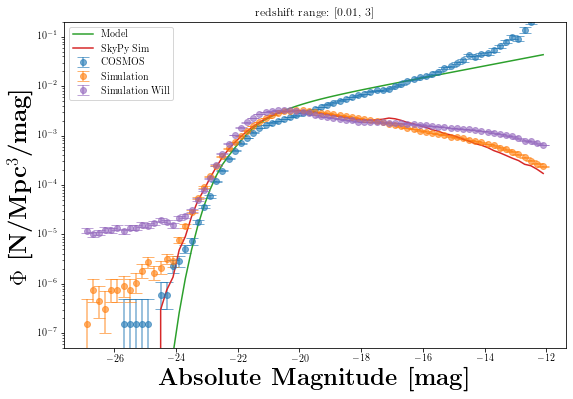

In [13]:
print("For comparison, the plot in redshift range [0,8] using Will's implementation"
      "can be found in /Users/philipp/Documents/PhD/lum_func_measurement/Vmax_Will_z0-8.png")
if np.min(sim['z']) > redshift_range[0]:
    z_min = np.min(sim['z'])
else:
    z_min = redshift_range[0]
if np.max(sim['z']) < redshift_range[1]:
    z_max = np.max(sim['z'])
else:
    z_max = redshift_range[1]
z = np.linspace(z_min, z_max, 100)
sky_area = Quantity(1.27, "deg2")
phi_model = lum_model(z, Mmid)

z_mask = np.logical_and(sim['z'] >= redshift_range[0], sim['z'] < redshift_range[1])
dV_dz = (cosmo.differential_comoving_volume(z) * sky_area).to_value('Mpc3')
dV = np.trapz(dV_dz, z)
dM = (np.max(Mbins)-np.min(Mbins)) / (np.size(Mbins)-1)
phi_skypy = np.histogram(sim['M_B'][z_mask], bins=Mbins)[0] / dV / dM

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"\textbf{Absolute Magnitude [mag]}", fontsize=24)
ax.set_ylabel(r'\textbf{$\Phi$ [N/Mpc$^3$/mag]}', fontsize=24)
#ax.set_xlim([-27,-12.5])
#ax.set_ylim([5.e-7,0.15])
ax.set_yscale('log')
ax.errorbar(Mmid, phi, yerr=np.array([phi_err_dn,phi_err_up]), alpha=0.6,
            fmt='o', capsize=6, label="COSMOS")
ax.errorbar(Mmid, phi_sim, yerr=np.array([phi_err_dn_sim,phi_err_up_sim]), alpha=0.6,
            fmt='o', capsize=6, label="Simulation")
ax.plot(Mmid, phi_model, label="Model")
ax.plot(Mmid, phi_skypy, label="SkyPy Sim")
ax.errorbar(Mmid, phi_sim_will, yerr=np.array([phi_err_dn_sim_will,phi_err_up_sim_will]), alpha=0.6,
            fmt='o', capsize=6, label="Simulation Will")
ax.set_ylim([5.e-8, 2.e-1])
plt.legend()
plt.title(f'redshift range: {redshift_range}')
plt.show()

### Vmax using kcorrection
Will's implementation does not include the kcorrection but only the bandpass correction. In this implementation, I include the kcorrection term at the reference redshift (the "true" redshift).

In [14]:
def Vmax_kcorrect(mag_lim, abs_mag, dm, vol, k_correct, z_ref):
    # compute the maximum observable volume an object has within the defined bin
    # I have to add 2.5*np.log10(1+z_ref) cause I account for the bandpass correction
    # in dm separately
    mag = abs_mag + dm + k_correct + 2.5*np.log10(1+z_ref)
    max_z_indexes = np.where(mag < mag_lim)[0]
    if len(max_z_indexes) == 0:
        max_z_indx = -1
    else:
        max_z_indx = max_z_indexes[-1]
    vmax = vol[max_z_indx] - vol[0]
    return vmax

def get_dm(z, cosmo):
    return 5*np.log10(cosmo.luminosity_distance(z).value * 1e5) - 2.5*np.log10(1+z)

def get_bin_weights_kcorrect(z, cosmo, area, zbin, abs_mag, maglim, k_correct):
    # compute Vmax for each object, based on their mag and survey maglim.
    # Objects lying outside the redshift intervals have weight = 0.
    # Set-up cosmo arrays
    zarr = np.arange(zbin[0], zbin[1]+(zbin[1]-zbin[0])/1000, (zbin[1]-zbin[0])/1000)
    # set up an array of dist. moduli - perhaps should have done this earlier in the code.
    dm = get_dm(zarr, cosmo)
    vol = (area/41252.96) * cosmo.comoving_volume(zarr).value

    weights = np.zeros_like(z)
    sel = np.where((z>=zbin[0])&(z<zbin[1]))[0]
    weights[sel] = np.array([1./Vmax_kcorrect(maglim, abs_mag[sel][j], dm,
                                     vol, k_correct[sel][j], z[sel][j]) for j in range(len(sel))])
    weights[np.isinf(weights)] = 0.
    return weights

In [38]:
redshift_range = [0.2, 0.4]

In [39]:
weights_kcorrection = get_bin_weights_kcorrect(cosmos['photoz'], cosmo, 1.27, 
                                        redshift_range, cosmos_abs_mag, 24.5, cosmos_k_correct)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


In [40]:
weights_sim_kcorrection = get_bin_weights_kcorrect(sim['z'], cosmo, 1.27, 
                                 redshift_range, abs_mag_sim_kcorrect, 24.5, sim_k_correct)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars


In [41]:
# calculate luminosity functions
Mbins = np.arange(-27,-12+0.2,0.2)
phi = np.histogram(cosmos_abs_mag, weights=weights_kcorrection, bins=Mbins)[0]
phi_sim = np.histogram(abs_mag_sim_kcorrect, weights=weights_sim_kcorrection, bins=Mbins)[0]

bin_widths = Mbins[1:] - Mbins[:-1]
phi = phi / bin_widths
phi_sim = phi_sim / bin_widths
Mmid = (Mbins[1:] + Mbins[:-1])/2.

# calculate errors of COSMOS
weff = np.ones_like(phi)
Neff = np.ones_like(phi)
for lbin in range(len(Mbins)-1):
    # Following Weigel+15
    mask = np.where((cosmos_abs_mag>=Mbins[lbin])&(cosmos_abs_mag<Mbins[lbin+1]))[0]
    weff[lbin] = effective_weight(weights_kcorrection[mask])
    Neff[lbin] = effective_number(weights_kcorrection[mask], weff[lbin])
phi_err_up = weff * (Neff + np.sqrt(Neff+0.75) + 1) / bin_widths - phi
phi_err_dn = phi - weff * (Neff - np.sqrt(Neff-0.25)) / bin_widths
# handle cases where N is zero - upper limit is 0.814 / max(Vmax)
phi_err_dn[np.isnan(phi_err_dn)] = 0.
phi_err_up[np.isnan(phi_err_up)] = 0.814 * np.min(weights_kcorrection[weights_kcorrection>0.])

# calculate errors of Sim
weff_sim = np.ones_like(phi_sim)
Neff_sim = np.ones_like(phi_sim)
for lbin in range(len(Mbins)-1):
    # Following Weigel+15
    mask = np.where((abs_mag_sim_kcorrect>=Mbins[lbin])&(abs_mag_sim_kcorrect<Mbins[lbin+1]))[0]
    weff_sim[lbin] = effective_weight(weights_sim_kcorrection[mask])
    Neff_sim[lbin] = effective_number(weights_sim_kcorrection[mask], weff_sim[lbin])
phi_err_up_sim = weff_sim * (Neff_sim + np.sqrt(Neff_sim+0.75) + 1) / bin_widths - phi_sim
phi_err_dn_sim = phi_sim - weff_sim * (Neff_sim - np.sqrt(Neff_sim-0.25)) / bin_widths
# handle cases where N is zero - upper limit is 0.814 / max(Vmax)
phi_err_dn_sim[np.isnan(phi_err_dn_sim)] = 0.
phi_err_up_sim[np.isnan(phi_err_up_sim)] = 0.814 * np.min(weights_sim_kcorrection[weights_sim_kcorrection>0.])

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


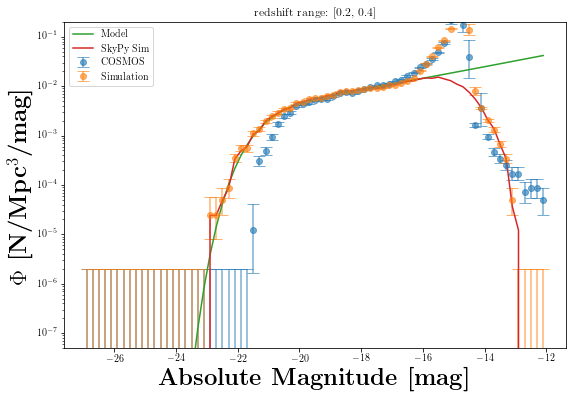

In [42]:
z = np.linspace(redshift_range[0], redshift_range[1], 100)
sky_area = Quantity(1.27, "deg2")
phi_model = lum_model(z, Mmid)

z_mask = np.logical_and(sim['z'] >= redshift_range[0], sim['z'] < redshift_range[1])
dV_dz = (cosmo.differential_comoving_volume(z) * sky_area).to_value('Mpc3')
dV = np.trapz(dV_dz, z)
dM = (np.max(Mbins)-np.min(Mbins)) / (np.size(Mbins)-1)
phi_skypy = np.histogram(sim['M_B'][z_mask], bins=Mbins)[0] / dV / dM

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"\textbf{Absolute Magnitude [mag]}", fontsize=24)
ax.set_ylabel(r'\textbf{$\Phi$ [N/Mpc$^3$/mag]}', fontsize=24)
#ax.set_xlim([-27,-12.5])
#ax.set_ylim([5.e-7,0.15])
ax.set_yscale('log')
ax.errorbar(Mmid, phi, yerr=np.array([phi_err_dn,phi_err_up]), alpha=0.6,
            fmt='o', capsize=6, label="COSMOS")
ax.errorbar(Mmid, phi_sim, yerr=np.array([phi_err_dn_sim,phi_err_up_sim]), alpha=0.6,
            fmt='o', capsize=6, label="Simulation")
ax.plot(Mmid, phi_model, label="Model")
ax.plot(Mmid, phi_skypy, label="SkyPy Sim")
ax.set_ylim([5.e-8, 2.e-1])
plt.legend()
plt.title(f'redshift range: {redshift_range}')
plt.show()

### K-correction implementation for array

This implementation improves the k-correction implementation by allowing the inputs to be arrays

In [15]:
def Vmax_kcorrect_array(mag_lim, abs_mag, dm, vol, k_correct, z_ref):
    # compute the maximum observable volume an object has within the defined bin
    mag = abs_mag[:,np.newaxis] + dm + k_correct[:,np.newaxis] + 2.5*np.log10(1+z_ref[:,np.newaxis])
    col_indices = mag.shape[-1] - np.argmax(mag[..., ::-1] < mag_lim, axis=-1) - 1
    row_indices = np.linspace(0, len(abs_mag)-1, len(abs_mag))
    vmax = vol[col_indices] - vol[0]
    return vmax

def get_dm(z, cosmo):
    return 5*np.log10(cosmo.luminosity_distance(z).value * 1e5) - 2.5*np.log10(1+z)

def get_bin_weights_kcorrect_array(z, cosmo, area, zbin, abs_mag, maglim, k_correct):
    # compute Vmax for each object, based on their mag and survey maglim.
    # Objects lying outside the redshift intervals have weight = 0.
    # Set-up cosmo arrays
    zarr = np.arange(zbin[0], zbin[1]+(zbin[1]-zbin[0])/1000, (zbin[1]-zbin[0])/1000)
    # set up an array of dist. moduli - perhaps should have done this earlier in the code.
    dm = get_dm(zarr, cosmo)
    vol = (area/41252.96) * cosmo.comoving_volume(zarr).value

    weights = np.zeros_like(z)
    sel = np.where((z>=zbin[0])&(z<zbin[1]))[0]
    weights[sel] = 1./Vmax_kcorrect_array(maglim, abs_mag[sel], dm, vol, k_correct[sel], z[sel])
    weights[np.isinf(weights)] = 0.
    return weights

# test
print("Test")
z = np.array([0.5, 1, 2])
abs_mag = np.array([-22, -15, -18])
k_correct = np.array([-0.42, -1.15, -0.7])

test_weights = get_bin_weights_kcorrect_array(z, cosmo, 1.27, [0, 3], abs_mag, 24.5, k_correct)
print(test_weights)

Test
[3.02047748e-08 1.23886810e-05 9.30319853e-07]


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


In [16]:
redshift_range = [0.01, 3]

In [19]:
weights_kcorrect_array = get_bin_weights_kcorrect_array(cosmos['photoz'], cosmo, 1.27, 
                                              redshift_range, cosmos_abs_mag, 24.5, cosmos_k_correct)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


In [20]:
weights_sim_kcorrect_array = get_bin_weights_kcorrect_array(sim['z'], cosmo, 1.27, 
                                                  redshift_range, abs_mag_sim_kcorrect, 24.5, sim_k_correct)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


In [21]:
# calculate luminosity fucntion
Mbins = np.arange(-27,-12+0.2,0.2)
phi = np.histogram(cosmos_abs_mag, weights=weights_kcorrect_array, bins=Mbins)[0]
phi_sim = np.histogram(abs_mag_sim_kcorrect, weights=weights_sim_kcorrect_array, bins=Mbins)[0]

bin_widths = Mbins[1:] - Mbins[:-1]
phi = phi / bin_widths
phi_sim = phi_sim / bin_widths
Mmid = (Mbins[1:] + Mbins[:-1])/2.

# calculate errors COSMOS
weff = np.ones_like(phi)
Neff = np.ones_like(phi)
for lbin in range(len(Mbins)-1):
    # Following Weigel+15
    mask = np.where((cosmos_abs_mag>=Mbins[lbin])&(cosmos_abs_mag<Mbins[lbin+1]))[0]
    weff[lbin] = effective_weight(weights_kcorrect_array[mask])
    Neff[lbin] = effective_number(weights_kcorrect_array[mask], weff[lbin])
phi_err_up = weff * (Neff + np.sqrt(Neff+0.75) + 1) / bin_widths - phi
phi_err_dn = phi - weff * (Neff - np.sqrt(Neff-0.25)) / bin_widths
# handle cases where N is zero - upper limit is 0.814 / max(Vmax)
phi_err_dn[np.isnan(phi_err_dn)] = 0.
phi_err_up[np.isnan(phi_err_up)] = 0.814 * np.min(weights_kcorrect_array[weights_kcorrect_array>0.])

# calculate errors Sim
weff_sim = np.ones_like(phi_sim)
Neff_sim = np.ones_like(phi_sim)
for lbin in range(len(Mbins)-1):
    # Following Weigel+15
    mask = np.where((abs_mag_sim_kcorrect>=Mbins[lbin])&(abs_mag_sim_kcorrect<Mbins[lbin+1]))[0]
    weff_sim[lbin] = effective_weight(weights_sim_kcorrect_array[mask])
    Neff_sim[lbin] = effective_number(weights_sim_kcorrect_array[mask], weff_sim[lbin])
phi_err_up_sim = weff_sim * (Neff_sim + np.sqrt(Neff_sim+0.75) + 1) / bin_widths - phi_sim
phi_err_dn_sim = phi_sim - weff_sim * (Neff_sim - np.sqrt(Neff_sim-0.25)) / bin_widths
# handle cases where N is zero - upper limit is 0.814 / max(Vmax)
phi_err_dn_sim[np.isnan(phi_err_dn_sim)] = 0.
phi_err_up_sim[np.isnan(phi_err_up_sim)] = 0.814 * np.min(weights_sim_kcorrect_array[weights_sim_kcorrect_array>0.])

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


For comparison, the plot in redshift range [0,8] using the simplified implementationcan be found in /Users/philipp/Documents/PhD/lum_func_measurement/Vmax_kcorrect_z0-8.png


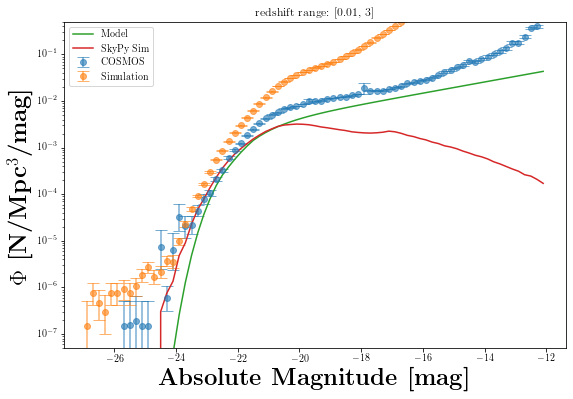

In [22]:
print("For comparison, the plot in redshift range [0,8] using the simplified implementation"
      "can be found in /Users/philipp/Documents/PhD/lum_func_measurement/Vmax_kcorrect_z0-8.png")
z = np.linspace(redshift_range[0], redshift_range[1], 100)
sky_area = Quantity(1.27, "deg2")
phi_model = lum_model(z, Mmid)

z_mask = np.logical_and(sim['z'] >= redshift_range[0], sim['z'] < redshift_range[1])
dV_dz = (cosmo.differential_comoving_volume(z) * sky_area).to_value('Mpc3')
dV = np.trapz(dV_dz, z)
dM = (np.max(Mbins)-np.min(Mbins)) / (np.size(Mbins)-1)
phi_skypy = np.histogram(sim['M_B'][z_mask], bins=Mbins)[0] / dV / dM

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"\textbf{Absolute Magnitude [mag]}", fontsize=24)
ax.set_ylabel(r'\textbf{$\Phi$ [N/Mpc$^3$/mag]}', fontsize=24)
#ax.set_xlim([-27,-12.5])
#ax.set_ylim([5.e-7,0.15])
ax.set_yscale('log')
ax.errorbar(Mmid, phi, yerr=np.array([phi_err_dn,phi_err_up]), alpha=0.6,
            fmt='o', capsize=6, label="COSMOS")
ax.errorbar(Mmid, phi_sim, yerr=np.array([phi_err_dn_sim,phi_err_up_sim]), alpha=0.6,
            fmt='o', capsize=6, label="Simulation")
ax.plot(Mmid, phi_model, label="Model")
ax.plot(Mmid, phi_skypy, label="SkyPy Sim")
ax.set_ylim([5.e-8, 5.e-1])
plt.legend()
plt.title(f'redshift range: {redshift_range}')
plt.show()

### Comparing Will's implementation and the broadcasted one

In [26]:
redshift_range = [0.2, 4]

In [27]:
weights = get_bin_weights(cosmos['photoz'], cosmo, 1.27, redshift_range, cosmos['UVISTA_Ks_MAG_APER3'], 24.5)
# weights_sim = get_bin_weights(sim['z'], cosmo, 1.27, redshift_range, sim['m_vista_sim'][:,3], 24.5)
weights_array = get_bin_weights_array(cosmos['photoz'], cosmo, 1.27, 
                                      redshift_range, cosmos['UVISTA_Ks_MAG_APER3'], 24.5)
# weights_sim_array = get_bin_weights_array(sim['z'], cosmo, 1.27, 
#                                           redshift_range, sim['m_vista_sim'][:,3], 24.5)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


In [28]:
# calculate the luminosity functions
Mbins = np.arange(-27,-12+0.2,0.2)
phi = np.histogram(cosmos_abs_mag, weights=weights, bins=Mbins)[0]
phi_sim = np.histogram(abs_mag_sim_kcorrect, weights=weights_sim, bins=Mbins)[0]

bin_widths = Mbins[1:] - Mbins[:-1]
phi = phi / bin_widths
phi_sim = phi_sim / bin_widths
Mmid = (Mbins[1:] + Mbins[:-1])/2.

# calculate errors for COSMOS
weff = np.ones_like(phi)
Neff = np.ones_like(phi)
for lbin in range(len(Mbins)-1):
    # Following Weigel+15
    mask = np.where((cosmos_abs_mag>=Mbins[lbin])&(cosmos_abs_mag<Mbins[lbin+1]))[0]
    weff[lbin] = effective_weight(weights[mask])
    Neff[lbin] = effective_number(weights[mask], weff[lbin])
phi_err_up = weff * (Neff + np.sqrt(Neff+0.75) + 1) / bin_widths - phi
phi_err_dn = phi - weff * (Neff - np.sqrt(Neff-0.25)) / bin_widths
# handle cases where N is zero - upper limit is 0.814 / max(Vmax)
phi_err_dn[np.isnan(phi_err_dn)] = 0.
phi_err_up[np.isnan(phi_err_up)] = 0.814 * np.min(weights[weights>0.])

# calculate errors for Sim
# weff_sim = np.ones_like(phi_sim)
# Neff_sim = np.ones_like(phi_sim)
# for lbin in range(len(Mbins)-1):
#     # Following Weigel+15
#     mask = np.where((abs_mag_sim_kcorrect>=Mbins[lbin])&(abs_mag_sim_kcorrect<Mbins[lbin+1]))[0]
#     weff_sim[lbin] = effective_weight(weights_sim[mask])
#     Neff_sim[lbin] = effective_number(weights_sim[mask], weff_sim[lbin])
# phi_err_up_sim = weff_sim * (Neff_sim + np.sqrt(Neff_sim+0.75) + 1) / bin_widths - phi_sim
# phi_err_dn_sim = phi_sim - weff_sim * (Neff_sim - np.sqrt(Neff_sim-0.25)) / bin_widths
# # handle cases where N is zero - upper limit is 0.814 / max(Vmax)
# phi_err_dn_sim[np.isnan(phi_err_dn_sim)] = 0.
# phi_err_up_sim[np.isnan(phi_err_up_sim)] = 0.814 * np.min(weights_sim[weights_sim>0.])

NameError: name 'weights_sim' is not defined

In [ ]:
# calculate luminosity functions
Mbins = np.arange(-27,-12+0.2,0.2)
phi_array = np.histogram(cosmos_abs_mag, weights=weights_array, bins=Mbins)[0]
phi_sim_array = np.histogram(abs_mag_sim_kcorrect, weights=weights_sim_array, bins=Mbins)[0]

bin_widths = Mbins[1:] - Mbins[:-1]
phi_array = phi_array / bin_widths
phi_sim_array = phi_sim_array / bin_widths
Mmid = (Mbins[1:] + Mbins[:-1])/2.

# calculate errors COSMOS
weff_array = np.ones_like(phi_array)
Neff_array = np.ones_like(phi_array)
for lbin in range(len(Mbins)-1):
    # Following Weigel+15
    mask = np.where((cosmos_abs_mag>=Mbins[lbin])&(cosmos_abs_mag<Mbins[lbin+1]))[0]
    weff_array[lbin] = effective_weight(weights_array[mask])
    Neff_array[lbin] = effective_number(weights_array[mask], weff[lbin])
phi_err_up_array = weff_array * (Neff_array + np.sqrt(Neff_array+0.75) + 1) / bin_widths - phi_array
phi_err_dn_array = phi_array - weff_array * (Neff_array - np.sqrt(Neff_array-0.25)) / bin_widths
# handle cases where N is zero - upper limit is 0.814 / max(Vmax)
phi_err_dn_array[np.isnan(phi_err_dn_array)] = 0.
phi_err_up_array[np.isnan(phi_err_up_array)] = 0.814 * np.min(weights_array[weights_array>0.])

# calculate errors Sim
# weff_sim_array = np.ones_like(phi_sim_array)
# Neff_sim_array = np.ones_like(phi_sim_array)
# for lbin in range(len(Mbins)-1):
#     # Following Weigel+15
#     mask = np.where((abs_mag_sim_kcorrect>=Mbins[lbin])&(abs_mag_sim_kcorrect<Mbins[lbin+1]))[0]
#     weff_sim_array[lbin] = effective_weight(weights_sim_array[mask])
#     Neff_sim_array[lbin] = effective_number(weights_sim_array[mask], weff_sim[lbin])
# phi_err_up_sim_array = weff_sim_array * (Neff_sim_array + np.sqrt(Neff_sim_array+0.75) + 1) / bin_widths - phi_sim_array
# phi_err_dn_sim_array = phi_sim_array - weff_sim_array * (Neff_sim_array - np.sqrt(Neff_sim_array-0.25)) / bin_widths
# # handle cases where N is zero - upper limit is 0.814 / max(Vmax)
# phi_err_dn_sim_array[np.isnan(phi_err_dn_sim_array)] = 0.
# phi_err_up_sim_array[np.isnan(phi_err_up_sim_array)] = 0.814 * np.min(weights_sim_array[weights_sim_array>0.])

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"\textbf{Absolute Magnitude [mag]}", fontsize=24)
ax.set_ylabel(r'\textbf{$\Phi$ [N/Mpc$^3$/mag]}', fontsize=24)
#ax.set_xlim([-27,-12.5])
#ax.set_ylim([5.e-7,0.15])
ax.set_yscale('log')
ax.errorbar(Mmid, phi, yerr=np.array([phi_err_dn,phi_err_up]), alpha=0.6,
            fmt='o', capsize=6, label="COSMOS")
# ax.errorbar(Mmid, phi_sim, yerr=np.array([phi_err_dn_sim,phi_err_up_sim]), alpha=0.6,
#             fmt='o', capsize=6, label="Simulation")
ax.errorbar(Mmid, phi_array, yerr=np.array([phi_err_dn_array,phi_err_up_array]), alpha=0.6,
            fmt='o', capsize=6, label="COSMOS Array")
# ax.errorbar(Mmid, phi_sim_array, yerr=np.array([phi_err_dn_sim_array,phi_err_up_sim_array]), alpha=0.6,
#             fmt='o', capsize=6, label="Simulation Array")
plt.legend()
plt.title(f"redshift range: {redshift_range}")
plt.show()

### Comparing the two k-correct implementations

In [56]:
redshift_range = [0.2, 0.4]

In [57]:
weights = get_bin_weights_kcorrect(cosmos['photoz'], cosmo, 1.27, 
                                        redshift_range, cosmos_abs_mag, 24.5, cosmos_k_correct)
weights_sim = get_bin_weights_kcorrect(sim['z'], cosmo, 1.27, 
                                 redshift_range, abs_mag_sim_kcorrect, 24.5, sim_k_correct)
weights_array = get_bin_weights_kcorrect_array(cosmos['photoz'], cosmo, 1.27, 
                                              redshift_range, cosmos_abs_mag, 24.5, cosmos_k_correct)
weights_sim_array = get_bin_weights_kcorrect_array(sim['z'], cosmo, 1.27, 
                                                  redshift_range, abs_mag_sim_kcorrect, 24.5, sim_k_correct)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


In [58]:
# calculate the luminosity functions
Mbins = np.arange(-27,-12+0.2,0.2)
phi = np.histogram(cosmos_abs_mag, weights=weights, bins=Mbins)[0]
phi_sim = np.histogram(abs_mag_sim_kcorrect, weights=weights_sim, bins=Mbins)[0]

bin_widths = Mbins[1:] - Mbins[:-1]
phi = phi / bin_widths
phi_sim = phi_sim / bin_widths
Mmid = (Mbins[1:] + Mbins[:-1])/2.

# calculate errors for COSMOS
weff = np.ones_like(phi)
Neff = np.ones_like(phi)
for lbin in range(len(Mbins)-1):
    # Following Weigel+15
    mask = np.where((cosmos_abs_mag>=Mbins[lbin])&(cosmos_abs_mag<Mbins[lbin+1]))[0]
    weff[lbin] = effective_weight(weights[mask])
    Neff[lbin] = effective_number(weights[mask], weff[lbin])
phi_err_up = weff * (Neff + np.sqrt(Neff+0.75) + 1) / bin_widths - phi
phi_err_dn = phi - weff * (Neff - np.sqrt(Neff-0.25)) / bin_widths
# handle cases where N is zero - upper limit is 0.814 / max(Vmax)
phi_err_dn[np.isnan(phi_err_dn)] = 0.
phi_err_up[np.isnan(phi_err_up)] = 0.814 * np.min(weights[weights>0.])

# calculate errors for Sim
weff_sim = np.ones_like(phi_sim)
Neff_sim = np.ones_like(phi_sim)
for lbin in range(len(Mbins)-1):
    # Following Weigel+15
    mask = np.where((abs_mag_sim_kcorrect>=Mbins[lbin])&(abs_mag_sim_kcorrect<Mbins[lbin+1]))[0]
    weff_sim[lbin] = effective_weight(weights_sim[mask])
    Neff_sim[lbin] = effective_number(weights_sim[mask], weff_sim[lbin])
phi_err_up_sim = weff_sim * (Neff_sim + np.sqrt(Neff_sim+0.75) + 1) / bin_widths - phi_sim
phi_err_dn_sim = phi_sim - weff_sim * (Neff_sim - np.sqrt(Neff_sim-0.25)) / bin_widths
# handle cases where N is zero - upper limit is 0.814 / max(Vmax)
phi_err_dn_sim[np.isnan(phi_err_dn_sim)] = 0.
phi_err_up_sim[np.isnan(phi_err_up_sim)] = 0.814 * np.min(weights_sim[weights_sim>0.])

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


In [59]:
# calculate luminosity functions
Mbins = np.arange(-27,-12+0.2,0.2)
phi_array = np.histogram(cosmos_abs_mag, weights=weights_array, bins=Mbins)[0]
phi_sim_array = np.histogram(abs_mag_sim_kcorrect, weights=weights_sim_array, bins=Mbins)[0]

bin_widths = Mbins[1:] - Mbins[:-1]
phi_array = phi_array / bin_widths
phi_sim_array = phi_sim_array / bin_widths
Mmid = (Mbins[1:] + Mbins[:-1])/2.

# calculate errors COSMOS
weff_array = np.ones_like(phi_array)
Neff_array = np.ones_like(phi_array)
for lbin in range(len(Mbins)-1):
    # Following Weigel+15
    mask = np.where((cosmos_abs_mag>=Mbins[lbin])&(cosmos_abs_mag<Mbins[lbin+1]))[0]
    weff_array[lbin] = effective_weight(weights_array[mask])
    Neff_array[lbin] = effective_number(weights_array[mask], weff[lbin])
phi_err_up_array = weff_array * (Neff_array + np.sqrt(Neff_array+0.75) + 1) / bin_widths - phi_array
phi_err_dn_array = phi_array - weff_array * (Neff_array - np.sqrt(Neff_array-0.25)) / bin_widths
# handle cases where N is zero - upper limit is 0.814 / max(Vmax)
phi_err_dn_array[np.isnan(phi_err_dn_array)] = 0.
phi_err_up_array[np.isnan(phi_err_up_array)] = 0.814 * np.min(weights_array[weights_array>0.])

# calculate errors Sim
weff_sim_array = np.ones_like(phi_sim_array)
Neff_sim_array = np.ones_like(phi_sim_array)
for lbin in range(len(Mbins)-1):
    # Following Weigel+15
    mask = np.where((abs_mag_sim_kcorrect>=Mbins[lbin])&(abs_mag_sim_kcorrect<Mbins[lbin+1]))[0]
    weff_sim_array[lbin] = effective_weight(weights_sim_array[mask])
    Neff_sim_array[lbin] = effective_number(weights_sim_array[mask], weff_sim[lbin])
phi_err_up_sim_array = weff_sim_array * (Neff_sim_array + np.sqrt(Neff_sim_array+0.75) + 1) / bin_widths - phi_sim_array
phi_err_dn_sim_array = phi_sim_array - weff_sim_array * (Neff_sim_array - np.sqrt(Neff_sim_array-0.25)) / bin_widths
# handle cases where N is zero - upper limit is 0.814 / max(Vmax)
phi_err_dn_sim_array[np.isnan(phi_err_dn_sim_array)] = 0.
phi_err_up_sim_array[np.isnan(phi_err_up_sim_array)] = 0.814 * np.min(weights_sim_array[weights_sim_array>0.])

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


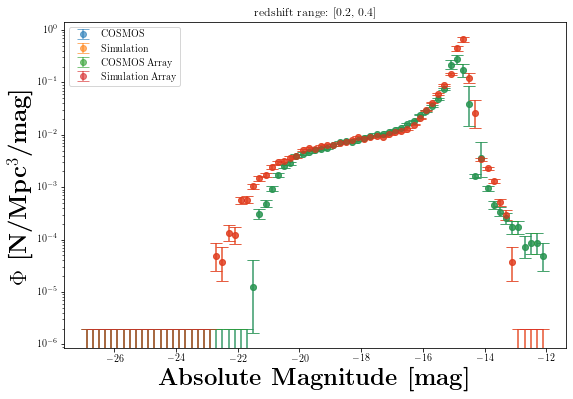

In [60]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"\textbf{Absolute Magnitude [mag]}", fontsize=24)
ax.set_ylabel(r'\textbf{$\Phi$ [N/Mpc$^3$/mag]}', fontsize=24)
#ax.set_xlim([-27,-12.5])
#ax.set_ylim([5.e-7,0.15])
ax.set_yscale('log')
ax.errorbar(Mmid, phi, yerr=np.array([phi_err_dn,phi_err_up]), alpha=0.6,
            fmt='o', capsize=6, label="COSMOS")
ax.errorbar(Mmid, phi_sim, yerr=np.array([phi_err_dn_sim,phi_err_up_sim]), alpha=0.6,
            fmt='o', capsize=6, label="Simulation")
ax.errorbar(Mmid, phi_array, yerr=np.array([phi_err_dn_array,phi_err_up_array]), alpha=0.6,
            fmt='o', capsize=6, label="COSMOS Array")
ax.errorbar(Mmid, phi_sim_array, yerr=np.array([phi_err_dn_sim_array,phi_err_up_sim_array]), alpha=0.6,
            fmt='o', capsize=6, label="Simulation Array")
plt.legend()
plt.title(f"redshift range: {redshift_range}")
plt.show()

### Test code for developing implementations

In [234]:
a = np.array([True, True, True, False])
b = np.array([False, False, False, False])

print(np.argmax(a))
print(np.argmax(b))

1
0


In [243]:
a = np.array([[3, 4, 6],
              [4, 6, 8],
              [6, 8, 10]])
condition = 8
print(a[..., ::-1])
print(a[..., ::-1] < condition)
print(a.shape[-1] - np.argmax(a[..., ::-1] < condition, axis=-1) - 1)

[[ 6  4  3]
 [ 8  6  4]
 [10  8  6]]
[[ True  True  True]
 [False  True  True]
 [False False  True]]
[2 1 0]
